Asset Allocation:
Invesco QQQ Trust: 9.38%
iShares MSCI USA Equal Weighted ETF: 10.04%
iShares Core MSCI Europe ETF: 7.95%
iShares MSCI Japan Value ETF: 8.24%
iShares J.P. Morgan USD Emerging Markets Bond ETF: 0.00%
Vanguard US Government Bond Index Fund: 11.34%
Vanguard High-Yield Corporate Fund Investor Shares: 2.18%
iShares iBoxx $ Investment Grade Corporate Bond ETF: 0.40%
Vanguard Total International Bond ETF: 2.89%
iShares Gold Trust: 5.00%
Cash: 2.50%
iShares Emerging Markets Infrastructure ETF: 4.75%
Vanguard Information Technology Index Fund ETF: 8.55%
iShares Future AI & Tech ETF: 4.75%
iShares ESG Aware MSCI EM ETF: 4.12%
iShares Global Utilities ETF: 1.48%
iShares Bitcoin Trust ETF: 3.23%
iShares Global Aerospace & Defence UCITS ETF: 13.20%
Portfolio Annualized Return: 10.00%
Portfolio Volatility: 5.30%


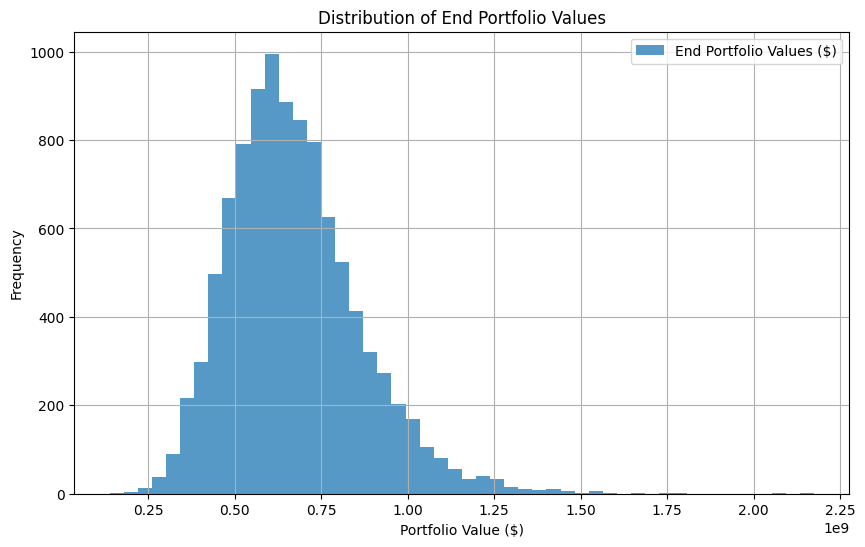

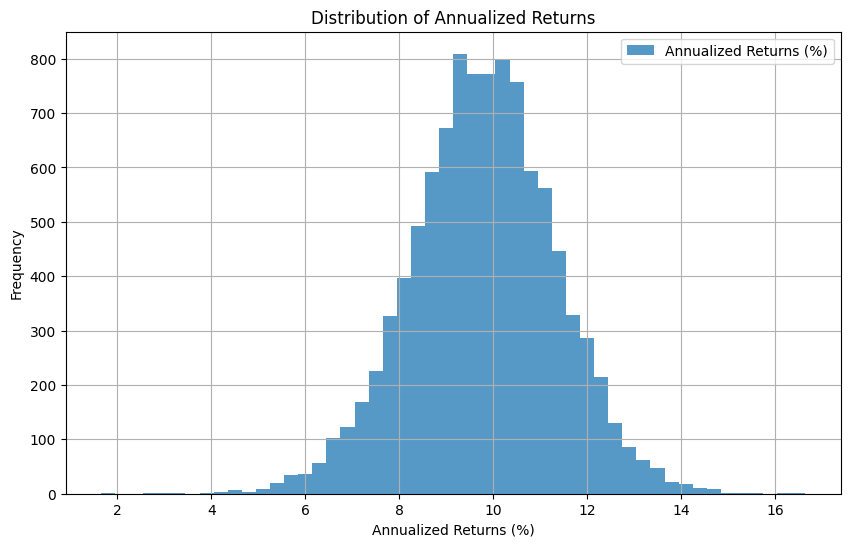

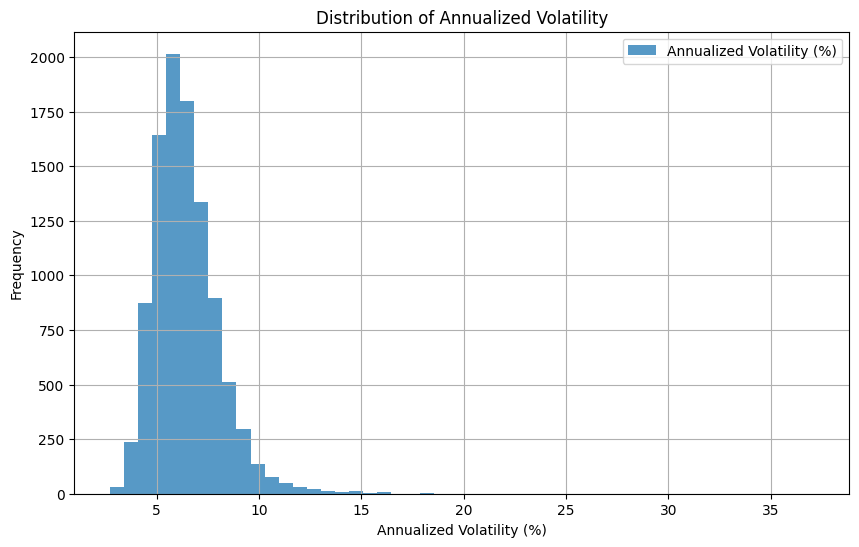

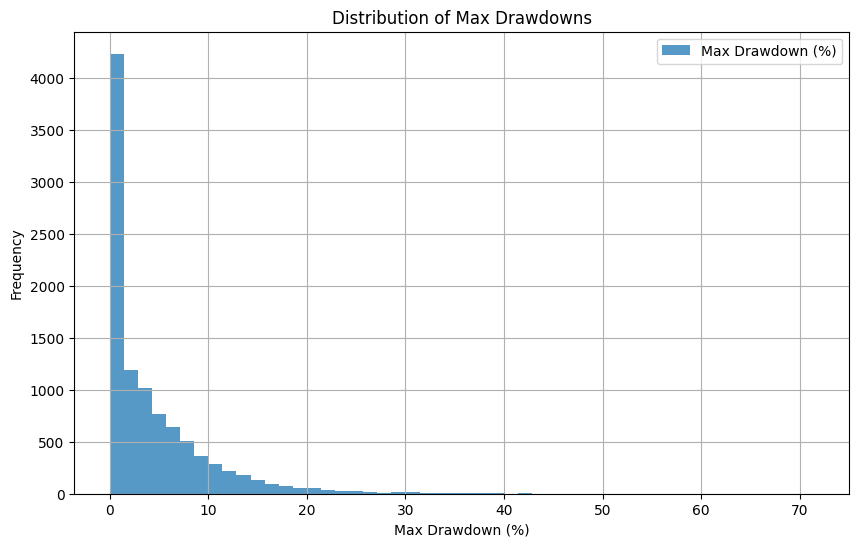

Summary Statistics:
End Portfolio Values: Mean = $672,022,777.81, Std Dev = $190,225,117.93
Annualized Returns: Mean = 9.79%, Std Dev = 1.54%
Annualized Volatility: Mean = 6.46%, Std Dev = 1.67%
Max Drawdowns: Mean = 4.30%, Std Dev = 5.83%


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import t

# Updated data with favored assets
data = {
    "ETF": [
        "Invesco QQQ Trust", 
        "iShares MSCI USA Equal Weighted ETF", 
        "iShares Core MSCI Europe ETF", 
        "iShares MSCI Japan Value ETF", 
        "iShares J.P. Morgan USD Emerging Markets Bond ETF", 
        "Vanguard US Government Bond Index Fund", 
        "Vanguard High-Yield Corporate Fund Investor Shares", 
        "iShares iBoxx $ Investment Grade Corporate Bond ETF", 
        "Vanguard Total International Bond ETF", 
        "iShares Gold Trust", 
        "Cash", 
        "iShares Emerging Markets Infrastructure ETF",
        "Vanguard Information Technology Index Fund ETF", 
        "iShares Future AI & Tech ETF", 
        "iShares ESG Aware MSCI EM ETF", 
        "iShares Global Utilities ETF", 
        "iShares Bitcoin Trust ETF",
        "iShares Global Aerospace & Defence UCITS ETF"
    ],
    "Annualised Returns": [
        0.1735, 0.0794, 0.0213, 0.0387, -0.0207, -0.0334, -0.0096, -0.0111, -0.0079, 0.0802, 0.0,
        -0.0433, 0.1953, 0.0628, 0.1281, 0.0270, 0.9921, 0.1194
    ],
    "Annualised Volatility": [
        0.2182, 0.1855, 0.1890, 0.1916, 0.0997, 0.1421, 0.0514, 0.0865, 0.0444, 0.1412, 0.0,
        0.2133, 0.2344, 0.2631, 0.1907, 0.1722, 0.5730, 0.1036
    ]
}

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Annualized return and covariance matrix
returns = np.array(df["Annualised Returns"])
volatility = np.array(df["Annualised Volatility"])
cov_matrix = np.diag(volatility ** 2)  # Assuming no correlation for simplicity; replace with real cov_matrix if available

# Portfolio Optimization Functions
def portfolio_return(weights, returns):
    return np.dot(weights, returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def objective_function(weights, returns, cov_matrix, target_return):
    # Minimize volatility while achieving target return
    penalty = abs(portfolio_return(weights, returns) - target_return)
    return portfolio_volatility(weights, cov_matrix) + penalty

# Constraints and bounds
target_return = 0.1
num_assets = len(returns)
bounds = [(0, 1) for _ in range(num_assets)]  # Weights between 0 and 1

# Indices for favored assets, Gold, and Cash
favored_indices = [0, 1, 2, 3, 5, 11, 12, 13]
gold_index = df[df["ETF"] == "iShares Gold Trust"].index[0]
cash_index = df[df["ETF"] == "Cash"].index[0]

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # Sum of weights = 1
    {"type": "ineq", "fun": lambda w: np.sum(w[favored_indices]) - 0.65},  # At least 50% weight to favored ETFs
    {"type": "eq", "fun": lambda w: w[gold_index] - 0.05},  # Gold fixed at 5%
    {"type": "eq", "fun": lambda w: w[cash_index] - 0.025}  # Cash fixed at 2.5%
]

# Initial guess
initial_weights = np.array([1 / num_assets] * num_assets)

# Optimization
result = minimize(
    objective_function, initial_weights,
    args=(returns, cov_matrix, target_return),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

# Extract optimized weights
optimized_weights = result.x

# Normalize the remaining weights to ensure the fixed allocations are preserved
remaining_indices = [i for i in range(num_assets) if i not in [gold_index, cash_index]]
remaining_weights = optimized_weights[remaining_indices]
remaining_weights = remaining_weights / np.sum(remaining_weights) * (1 - 0.05 - 0.025)
optimized_weights[remaining_indices] = remaining_weights
optimized_weights[gold_index] = 0.05  # Ensure Gold is exactly 5%
optimized_weights[cash_index] = 0.025  # Ensure Cash is exactly 2.5%

# Calculate portfolio metrics
portfolio_ret = portfolio_return(optimized_weights, returns)
portfolio_vol = portfolio_volatility(optimized_weights, cov_matrix)

# Asset Allocation Output
print("Asset Allocation:")
for etf, weight in zip(df["ETF"], optimized_weights):
    print(f"{etf}: {weight * 100:.2f}%")

# Portfolio Metrics
print(f"Portfolio Annualized Return: {portfolio_ret * 100:.2f}%")
print(f"Portfolio Volatility: {portfolio_vol * 100:.2f}%")

# Monte Carlo Simulation Parameters
monte_carlo_runs = 10000
end_portfolio_values = []
annualized_returns = []
annualized_volatility = []
max_drawdowns = []
time_horizon = 20
initial_value = 100000000  # Start balance of $100 million

def calculate_max_drawdown(values):
    cumulative_max = np.maximum.accumulate(values)
    drawdowns = (cumulative_max - values) / cumulative_max
    return np.max(drawdowns)

# Monte Carlo Simulation
for _ in range(monte_carlo_runs):
    portfolio_values = [initial_value]
    for year in range(1, time_horizon + 1):
        annual_growth = t.rvs(df=5, loc=portfolio_ret, scale=portfolio_vol)
        portfolio_values.append(portfolio_values[-1] * (1 + annual_growth))
    
    end_value = portfolio_values[-1]
    total_return = (end_value / initial_value) - 1
    if total_return >= -1:
        annualized_return = np.sign(1 + total_return) * (abs(1 + total_return) ** (1 / time_horizon) - 1)
    else:
        annualized_return = -1  # Total loss (portfolio value reaches near zero)

    annualized_vol = np.std([(portfolio_values[i] / portfolio_values[i - 1] - 1) for i in range(1, len(portfolio_values))])

    end_portfolio_values.append(end_value)
    annualized_returns.append(annualized_return)
    annualized_volatility.append(annualized_vol)
    max_drawdowns.append(calculate_max_drawdown(portfolio_values))

# Results and Distributions
end_portfolio_values = np.array(end_portfolio_values)
annualized_returns = np.array(annualized_returns)
annualized_volatility = np.array(annualized_volatility)
max_drawdowns = np.array(max_drawdowns)

# Plot Distributions
plt.figure(figsize=(10, 6))
plt.hist(end_portfolio_values, bins=50, alpha=0.75, label="End Portfolio Values ($)")
plt.xlabel("Portfolio Value ($)")
plt.ylabel("Frequency")
plt.title("Distribution of End Portfolio Values")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(annualized_returns * 100, bins=50, alpha=0.75, label="Annualized Returns (%)")
plt.xlabel("Annualized Returns (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Annualized Returns")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(annualized_volatility * 100, bins=50, alpha=0.75, label="Annualized Volatility (%)")
plt.xlabel("Annualized Volatility (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Annualized Volatility")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(max_drawdowns * 100, bins=50, alpha=0.75, label="Max Drawdown (%)")
plt.xlabel("Max Drawdown (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Max Drawdowns")
plt.legend()
plt.grid(True)
plt.show()

# Output summary statistics
print("Summary Statistics:")
print(f"End Portfolio Values: Mean = ${np.mean(end_portfolio_values):,.2f}, Std Dev = ${np.std(end_portfolio_values):,.2f}")
print(f"Annualized Returns: Mean = {np.mean(annualized_returns) * 100:.2f}%, Std Dev = {np.std(annualized_returns) * 100:.2f}%")
print(f"Annualized Volatility: Mean = {np.mean(annualized_volatility) * 100:.2f}%, Std Dev = {np.std(annualized_volatility) * 100:.2f}%")
print(f"Max Drawdowns: Mean = {np.mean(max_drawdowns) * 100:.2f}%, Std Dev = {np.std(max_drawdowns) * 100:.2f}%")